In [1]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = False
import random
import csv
import pandas as pd
# import h5py
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Normalize 
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
from collections import OrderedDict
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

In [2]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], 
                 reg: bool = False, activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            # For the final layer, do/do not use a bias term (user choice)
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# Read in data

In [6]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["D", "S", "tau"]
out_vars = ["p"]
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_train_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_test_data.csv"))
# # Convert to PyTorch Datasets as we defined them
# train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.fit_transform 
# test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.transform
# # Then create dataloaders, with batch size 32, from datasets
# train_dataloader = DataLoader(train_dataset, batch_size=32)
# test_dataloader  = DataLoader(test_dataset, batch_size=32)

Get the mu for output:

In [7]:
for df in [train_df, test_df]:
    W = np.sqrt(1/(1-df["v"]**2))
    h = 1 + df["eps"] + (df["p"]/df["rho"])
    
    df["mu"] = 1/(W*h)

In [8]:
df

rho       eps         v          p          D          S  \
0      9.836323  1.962039  0.266066  12.866164  10.204131  12.026585   
1      5.203042  1.522893  0.669504   5.282451   7.004551  22.337426   
2      8.591172  0.739712  0.441473   4.236664   9.574739  10.518784   
3      0.626353  1.392560  0.585310   0.581489   0.772503   1.851943   
4     10.087245  0.222690  0.637219   1.497551  13.088716  14.838680   
...         ...       ...       ...        ...        ...        ...   
9995   2.354663  1.431949  0.609409   2.247838   2.969850   7.730559   
9996   0.646230  0.874169  0.072389   0.376610   0.647930   0.115541   
9997   0.854028  1.505251  0.331675   0.857018   0.905272   1.116739   
9998   6.153600  1.333735  0.350154   5.471517   6.569503   7.914822   
9999   6.660209  1.069716  0.373827   4.749686   7.180830   8.054216   

            tau        mu  
0     22.131297  0.225747  
1     21.077156  0.209942  
2     10.015183  0.401851  
3      1.810045  0.244151  
4      8.700349  0.562070  
...         ...       ...  
9995   7.467644  0.234117  
9996   0.571578  0.405941  
9997   1.604678  0.268869  
9998  10.562783  0.290637  
9999   9.614791  0.333290  

[10000 rows x 8 columns]

Convert to appropriate output

In [9]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["D", "S", "tau"]
out_vars = ["mu"]
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

# Train network

In [10]:
model = Net(h=[10, 10], output_bias=True).float()
device = "cpu"
model

Net(
  (linear1): Linear(in_features=3, out_features=10, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
nnc2p.count_parameters(model)

161

In [12]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [13]:
# trainer.train()

In [14]:
# torch.save(model, "../Models/nn_assist_10_10_sigmoid.pt")

## Test its performance

In [132]:
model = torch.load("../Models/nn_assist_10_10_sigmoid.pt")

In [133]:
x = np.transpose(np.array([train_df["D"].values, train_df["S"].values, train_df["tau"].values]))
y = train_df["mu"].values

# Predict
with torch.no_grad():
    x       = torch.from_numpy(x).float()
    yhat = model(x)
    yhat = yhat.numpy()

## Take for a spin

In [134]:
x = torch.Tensor([0.90437025614154176, 0.70543713884138814, 1.6228154380654374]).float()
x = torch.Tensor([1.1142615696244609, 0.52933694956096999, 1.7985517610787460]).float()

with torch.no_grad():
    y = model(x)
    y = y.item()
print(y)
print([0.9*y, 1.1*y])

0.2722380757331848
[0.24501426815986635, 0.2994618833065033]


In [137]:
x = torch.Tensor([1, 1, 1]).float()

with torch.no_grad():
    y = model(x)
    y = y.item()
print(y)
print([0.9*y, 1.1*y])

0.41238653659820557
[0.371147882938385, 0.45362519025802617]


In [138]:
model.state_dict()["linear3.bias"]

tensor([-0.1158])

## Analyze the results

In [165]:
simulation = "Shocktube"
simulation_dir = os.path.join("../Data/NN assist", simulation)
print(os.path.abspath(simulation_dir))

D:\Coding\master-thesis-AI\Data\NN assist\Shocktube


In [166]:
path = os.path.join(simulation_dir, "counts_old.dat")
counts_old = np.loadtxt(path)
path = os.path.join(simulation_dir, "counts_new.dat")
counts_new = np.loadtxt(path)

In [167]:
print(f"Without assist: {np.mean(counts_old)} +- {np.std(counts_old)}")
print(f"With       assist: {np.mean(counts_new)} +- {np.std(counts_new)}")

Without assist: 3.8004432965140773 +- 1.9823067885472485
With       assist: 3.171163744939642 +- 1.579099339667568


# Neural networks and rootfinding

## Toy problem

In [23]:
def func(a, x):
    return x**3 - a

Get feature data:

In [96]:
a_min = -10
a_max = 10

x_min = -20
x_max = 20

size = 100000

a_vals = a_min + (a_max - a_min) * np.random.random_sample(size=size)
x_vals = x_min + (x_max - x_min) * np.random.random_sample(size=size)

features = np.transpose(np.array([a_vals, x_vals]))
features

array([[  5.09164693,  13.0588819 ],
       [  7.39640196,  11.41696937],
       [  7.64242544,  -8.41634678],
       ...,
       [  8.9670572 , -11.65069275],
       [ -4.34317403, -14.66910896],
       [  2.28791808, -12.90509712]])

In [97]:
features.shape

(100000, 2)

Get labels data:

In [98]:
labels = func(features[:, 0], features[:, 1]).reshape(-1, 1)
labels

array([[ 2221.89689582],
       [ 1480.77347049],
       [ -603.81344994],
       ...,
       [-1590.41626599],
       [-3152.19614419],
       [-2151.52255687]])

Convert to float32

In [99]:
features = features.astype(np.float32)
labels = labels.astype(np.float32)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [111]:
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
scaler.fit(X_train)
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(X_train, y_train, normalization_function = scaler.transform)  # scaler.fit_transform 
test_dataset  = data.HDF5Dataset(X_test, y_test, normalization_function = scaler.transform)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Define model

In [130]:
model = Net(nb_of_inputs = 2, nb_of_outputs = 1, h = [50, 50], activation_function=torch.nn.Sigmoid).float()
model

Net(
  (linear1): Linear(in_features=2, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

Train

In [131]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [132]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 1.91E+06
Test  loss: 1.91E+06

 Epoch 1 
 --------------
Train loss: 5.52E+05
Test  loss: 5.57E+05

 Epoch 2 
 --------------
Train loss: 1.40E+05
Test  loss: 1.44E+05

 Epoch 3 
 --------------
Train loss: 3.36E+04
Test  loss: 3.49E+04

 Epoch 4 
 --------------
Train loss: 1.59E+04
Test  loss: 1.60E+04

 Epoch 5 
 --------------
Train loss: 1.36E+04
Test  loss: 1.38E+04

 Epoch 6 
 --------------
Train loss: 4.66E+04
Test  loss: 4.68E+04

 Epoch 7 
 --------------
Train loss: 1.05E+04
Test  loss: 1.04E+04

 Epoch 8 
 --------------
Train loss: 2.45E+04
Test  loss: 2.50E+04

 Epoch 9 
 --------------
Train loss: 3.53E+04
Test  loss: 3.42E+04

 Epoch 10 
 --------------
Train loss: 1.03E+04
Test  loss: 1.03E+04

 Epoch 11 
 --------------
Train loss: 1.01E+04
Test  loss: 9.94E+03

 Epoch 12 
 --------------
Train loss: 9.93E+03
Test  loss: 9.83E+03

 Epoch 13 
 --------------
Train loss: 1.03E+04
Test  loss: 1.05

Train loss: 7.90E+00
Test  loss: 8.27E+00

 Epoch 116 
 --------------
Train loss: 7.74E+00
Test  loss: 8.11E+00

 Epoch 117 
 --------------
Train loss: 7.61E+00
Test  loss: 7.99E+00

 Epoch 118 
 --------------
Train loss: 7.49E+00
Test  loss: 7.87E+00

 Epoch 119 
 --------------
Train loss: 7.38E+00
Test  loss: 7.75E+00

 Epoch 120 
 --------------
Train loss: 7.27E+00
Test  loss: 7.63E+00

 Epoch 121 
 --------------
Train loss: 7.16E+00
Test  loss: 7.52E+00

 Epoch 122 
 --------------
Train loss: 7.06E+00
Test  loss: 7.41E+00

 Epoch 123 
 --------------
Train loss: 6.96E+00
Test  loss: 7.30E+00

 Epoch 124 
 --------------
Train loss: 6.85E+00
Test  loss: 7.19E+00

 Epoch 125 
 --------------
Train loss: 6.74E+00
Test  loss: 7.07E+00

 Epoch 126 
 --------------
Train loss: 6.63E+00
Test  loss: 6.95E+00

 Epoch 127 
 --------------
Train loss: 6.51E+00
Test  loss: 6.83E+00

 Epoch 128 
 --------------
Train loss: 6.40E+00
Test  loss: 6.70E+00

 Epoch 129 
 --------------
Train 

KeyboardInterrupt: 

Test:

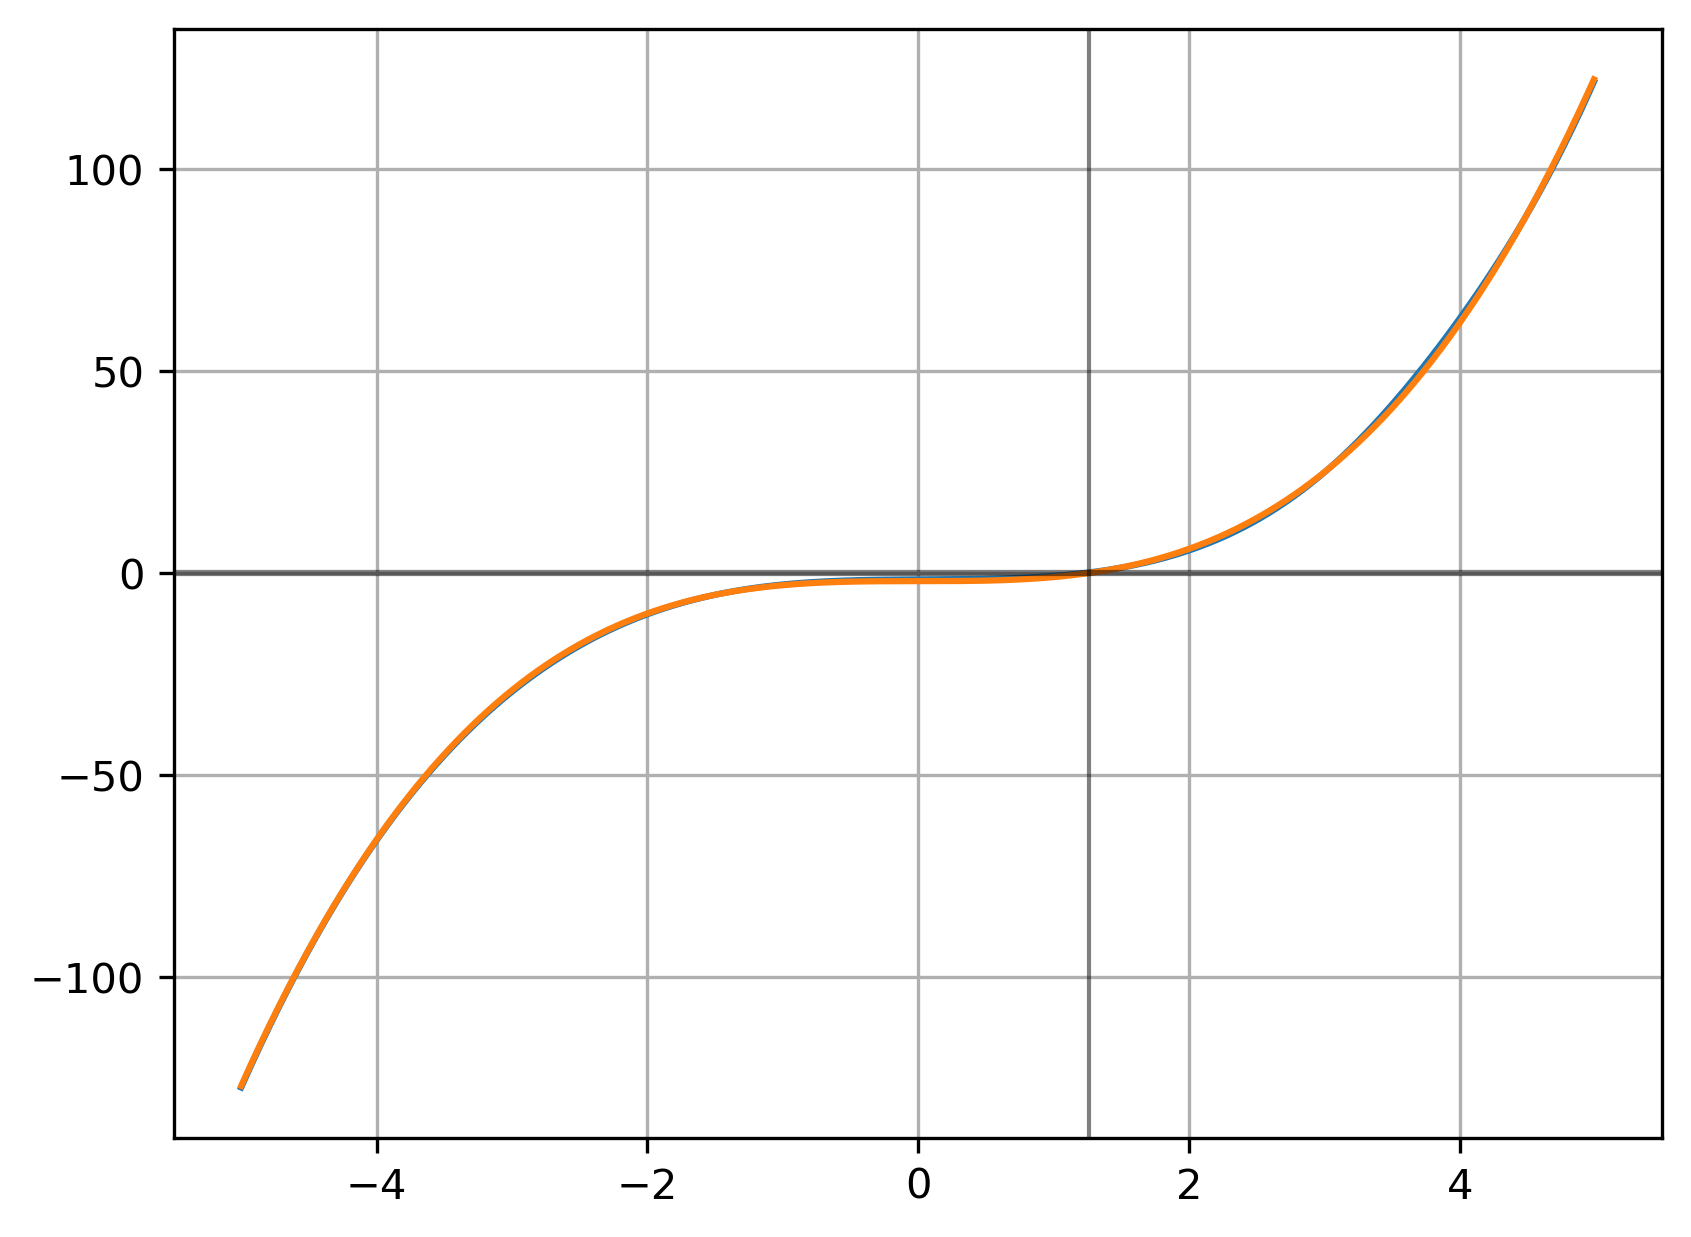

In [141]:
a = 2

x_vals = np.arange(-5, 5, 0.01)
true_vals = func(a, x_vals)

a_vals = np.array([a for _ in range(len(x_vals))])
input_vals = np.transpose(np.array([a_vals, x_vals]))
input_vals = scaler.transform(input_vals)

with torch.no_grad():
    input_vals = torch.from_numpy(input_vals).float()
    y_vals = model(input_vals)
    y_vals = y_vals.numpy()
    
plt.plot(x_vals, y_vals, label = "NN")
plt.plot(x_vals, true_vals, label = "True")
plt.axhline(0, color="black", alpha=0.5)
plt.axvline(a**(1/3), color="black", alpha=0.5, lw=1)
plt.grid()
plt.show()

In [136]:
# torch.save(model, "../Models/toy_problem.pt")

## Testing

In [143]:
features.shape

(100000, 2)

Get the params by hand:

In [147]:
W1 = model.state_dict()["linear1.weight"].detach()
b1 = model.state_dict()["linear1.bias"].detach()
W2 = model.state_dict()["linear2.weight"].detach()
b2 = model.state_dict()["linear2.bias"].detach()
W3 = model.state_dict()["linear3.weight"].detach()
b3 = model.state_dict()["linear3.bias"].detach()

In [159]:
W3.shape

torch.Size([1, 50])

In [154]:
def compute_z(x, W, b):
    return np.matmul(W, x) + b

def compute_activation(x, W, b):
    return sigmoid(compute_z(x, W, b))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [155]:
test1 = np.array([2, 2, 2])
test2 = np.array([1,2,3])
test1*test2

array([2, 4, 6])

In [228]:
def compute_gradient(x0):
    """x0 is the input for the neural network"""
    with torch.no_grad():
        # Forward pass:
        z1 = compute_z(x0, W1, b1)
        x1 = sigmoid(z1)
        z2 = compute_z(x1, W2, b2)
        x2 = sigmoid(z2)
        z3 = compute_z(x2, W3, b3)
        # Compute backward pass
        # TODO - sign correct or not?
        delta3 = -z3
        delta2 = np.matmul(W3, delta3.T) * sigmoid_prime(z2)
        delta1 = np.matmul(W2, delta2.T) * sigmoid_prime(z1)
        
        return delta1

In [229]:
x0 = np.array([0.2, 4]).reshape(1, -1)
print(x0.shape)
x0 = scaler.transform(x0)
x0 = torch.from_numpy(x0).float()

(1, 2)


Compute gradient

In [230]:
gradient = compute_gradient(x0.T)
gradient

C:\Users\thibe\AppData\Local\Temp\ipykernel_2016\2712056450.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -2.8546e-05,
         -6.8288e+00, -2.1327e+06],
        [-0.0000e+00, -9.6116e+00, -2.9014e+02,  ..., -5.2971e-10,
         -6.0414e-05, -1.8932e+02],
        [-0.0000e+00, -2.2782e+01, -5.6745e+02,  ..., -9.6341e-10,
         -1.3908e-04, -4.5408e+02],
        ...,
        [-0.0000e+00, -0.0000e+00, -1.7986e+02,  ..., -1.5044e-07,
         -1.9035e-02, -6.9563e+04],
        [ 0.0000e+00,  8.6908e+01,  5.8208e+02,  ...,  2.1708e-09,
          2.1287e-04,  1.3933e+03],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -1.4572e-07,
         -1.3379e-02, -7.3015e+04]])

Using PyTorch (preferably not!)

In [231]:
a_vals = np.array([a for _ in range(len(x_vals))])
x_vals = np.arange(-5, 5, 0.01)

In [233]:
def compute_gradient(input_vals):
    preds = model(input_vals)
    grd = torch.zeros ((1, 1)) # same shape as preds
    grd[0, 0] = 1 # column of Jacobian to compute
    preds.backward(gradient = grd, retain_graph = True)
    J[:,0] = input_vals.grad.view(2).float() # fill in one column of Jacobian
    input_vals.grad.zero_() # .backward() accumulates gradients, so reset to zero
    
    return J

Initialize jacobian:

In [268]:
J = torch.zeros((2, 1)) # loop will fill in Jacobian
J = J.float()

Get input as tensor

In [269]:
input_vals = np.transpose(np.array([0.2, 4]))
input_vals = scaler.transform(input_vals.reshape(1, -1))
input_vals = torch.from_numpy(input_vals).float()

In [270]:
input_vals

tensor([[0.0395, 0.3507]])

Finally, compute gradient

In [271]:
input_vals.requires_grad_()
J = compute_gradient(input_vals)
print(J)

tensor([[ -4.4239],
        [538.0892]])


In [272]:
J[1]

tensor([538.0892])

In [273]:
input_vals = input_vals.detach()
input_vals[0,1] = input_vals[0,1] - 0.01 * J[1]
input_vals

tensor([[ 0.0395, -5.0302]])

__Loop:__

In [287]:
n_loops = 100
alph = 0.0001
input_vals = np.transpose(np.array([0.2, 4]))
input_vals = scaler.transform(input_vals.reshape(1, -1))
input_vals = torch.from_numpy(input_vals).float()

for i in range(n_loops):
    preds = model(input_vals)
#     print(preds)
    # Initialize Jacobian
    J = torch.zeros((2, 1))
    J = J.float()
    # Require grad, compute grad
    input_vals.requires_grad_()
    J = compute_gradient(input_vals)
    grad = J[1]
    print(grad)
    if grad > 0:
        sign = + 1
    else:
        sign = -1
    # Disable grad, update params
    input_vals = input_vals.detach()
    input_vals[0,1] = input_vals[0,1] - sign * alph * grad

tensor([538.0892])
tensor([412.5381])
tensor([303.4356])
tensor([227.1191])
tensor([177.6713])
tensor([144.2197])
tensor([120.3295])
tensor([102.5062])
tensor([88.7305])
tensor([77.8156])
tensor([68.9595])
tensor([61.6702])
tensor([55.5640])
tensor([50.4009])
tensor([45.9799])
tensor([42.1520])
tensor([38.8241])
tensor([35.9136])
tensor([33.3299])
tensor([31.0476])
tensor([29.0091])
tensor([27.1809])
tensor([25.5225])
tensor([24.0342])
tensor([22.6840])
tensor([21.4528])
tensor([20.3302])
tensor([19.3008])
tensor([18.3549])
tensor([17.4845])
tensor([16.6812])
tensor([15.9374])
tensor([15.2493])
tensor([14.6086])
tensor([14.0145])
tensor([13.4593])
tensor([12.9401])
tensor([12.4567])
tensor([12.0039])
tensor([11.5779])
tensor([11.1793])
tensor([10.8026])
tensor([10.4505])
tensor([10.1172])
tensor([9.8033])
tensor([9.5077])
tensor([9.2264])
tensor([8.9609])
tensor([8.7100])
tensor([8.4714])
tensor([8.2464])
tensor([8.0315])
tensor([7.8274])
tensor([7.6348])
tensor([7.4510])
tensor([7.276